In [1]:
using Pkg
Pkg.activate("/Users/mathieu/Documents/AdaptiveTransportMap/")

 Activating environment at `~/Documents/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [19]:
path = "/Users/mathieu/Documents/AdaptiveTransportMap/src/lorenz96/data/"
Nx = 40
Ny = 20
Ne = 100
@time model, data = setup_lorenz96(path, [Ne]);

Ne 100 RMSE: 0.2932657550478545
  7.635286 seconds (16.58 M allocations: 3.543 GiB, 9.96% gc time)


In [4]:
Nx = 40
Ny = 20

# The state is measured every fourth
Δ = 2
yidx = 1:Δ:Nx

Δtdyn = 0.01
Δtobs = 0.4

σx = 1e-2#1e-6#1e-2
σy = sqrt(0.5)#1e-6#2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
tspinup = 200.0
Tspinup = 2000
tmetric = 400.0
Tmetric = 4000
t0 = 0.0
tf = 600.0
Tf = 6000

Tburn = 2000
Tstep = 4000
Tspinup = 2000

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz96!
h(t,x) = x[yidx]
# Create a local version of the observation operator
h(t,x,idx) = x[idx]

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, Tburn, Tstep, Tspinup, f, h);

# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

40-element Array{Float64,1}:
  2.35702516439035
 -0.6974596535466504
  0.7767795778848651
  1.5636178693869298
  0.23124580553439136
  0.08848845871635681
 -1.1848851154166864
 -0.37104559542260407
  0.5641149216671475
  0.3693130243027371
  1.2893400332359595
 -0.7635978786911809
 -0.6452291306120573
  ⋮
  1.7843125954949768
  0.468663770933171
  1.9440826967259834
 -1.9502107718951478
  0.9141121377049231
 -0.4882774535715776
 -0.5583379532948423
  0.03159168383492487
 -0.11584539803788778
 -0.7277161641675015
  0.7165600009345178
  0.6790878360141451

In [5]:
# Run dynamics and generate data
data = generate_lorenz96(model, x0, model.Tspinup+model.Tstep);

In [6]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

J = model.Tspinup+model.Tstep
t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
# enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)
enkf = ETKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, 50*model.Δtobs, false, false)

ETKF  with filtered = false


In [7]:
statehist = seqassim(dyn, data, J, model.ϵx, enkf, X, model.Ny, model.Nx, t0);

In [8]:
metric_hist(rmse, data.xt, statehist[2:end])[3]

0.24251737722859726

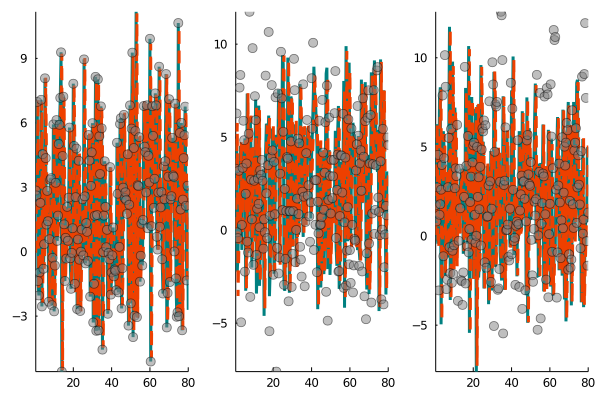

In [9]:
nb = 1
ne = 200
Δ = 1
plt = plot(layout  = grid(1,3))#, size = (1200, 600))
# dict = [L"x_1" L"x_2" L"x_3"]
for i=1:3
# plot!(plt[1,i], label = [L"y_k" "Truth" "smap1"])
plot!(plt[1,i], data.tt[nb:ne], data.xt[i,nb:ne], linewidth =  3, color = :teal, xlabel = "", 
        ylabel = "", label = "")
plot!(plt[1,i], data.tt[nb:Δ:ne], mean_hist(statehist)[i,nb:Δ:ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3, label = "")
scatter!(plt[1,i], data.tt[nb:ne], data.yt[i,nb:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5,
    xlim = (-Inf, Inf), ylim = (-Inf, Inf), label = "")

end

plt

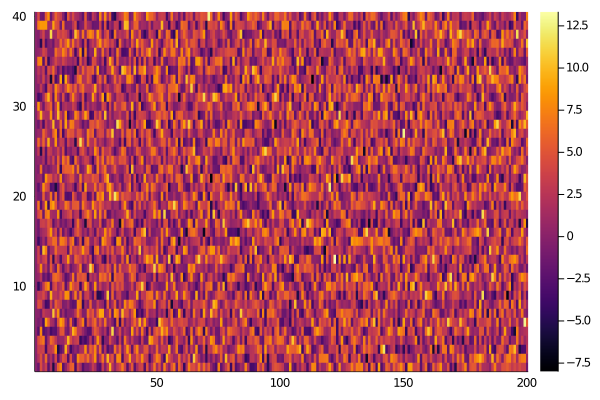

In [18]:
heatmap(mean_hist(statehist)[:,1:5:1000])